# Danielle Shelton - additional Project 3

For this additional work I looked at the Historical stock data for DIJA 30 companies and chose to work with CAT specifically. This is a daily time series from January 1st 2006 to January 1st of 2018. I had two goals - one to predict where the closing price would go, and two, to see accurate results using ARIMA and SARIMA.

https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231

Import Libraries

In [1]:
import yfinance as yahooFinance
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Import Dataset

In [2]:
df = pd.read_csv('CAT_2006-01-01_to_2018-01-01.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,57.87,58.11,57.05,57.80,3697500,CAT
1,2006-01-04,57.95,59.43,57.55,59.27,4577200,CAT
2,2006-01-05,59.02,59.86,59.00,59.27,4590700,CAT
3,2006-01-06,59.47,60.76,59.38,60.45,5692300,CAT
4,2006-01-09,60.45,61.68,60.45,61.55,4409300,CAT


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
 6   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.3+ KB


In [5]:
df.shape

(3020, 7)

This is a typical stock file containing 7 columns including the Date, the daily Opening price, the daily High, daily Low, the daily Closing price, the Volume and stock Name. There are no null values. 

I chose to work with the the Close price and for simplicities sake created a second dataset including Date and Close, the only features I will be working with. 

In [6]:
price = df[['Date', 'Close']]
price.head()

,Date,Close
0,2006-01-03,57.80
1,2006-01-04,59.27
2,2006-01-05,59.27
3,2006-01-06,60.45
4,2006-01-09,61.55


Make 'Date' the Index

In [7]:
price.index = pd.to_datetime(price['Date'], format='%Y-%m-%d')
del price['Date']
price.head()

,Close
Date,
2006-01-03,57.80
2006-01-04,59.27
2006-01-05,59.27
2006-01-06,60.45
2006-01-09,61.55


I created an Autocorrelation Function to see how the daily closing price is effect by the closing price of the previous day and multiple days before that. Using both a heatmap and plot we can see there is a strong correlation between the day's closing cost and the days prior to it. 

In [8]:
price1 = pd.DataFrame(price['Close'].values)
acf_df = pd.concat([price1.shift(15),price1.shift(14),price1.shift(13),price1.shift(12),price1.shift(11),price1.shift(10),price1.shift(9),price1.shift(8),price1.shift(7),price1.shift(6),price1.shift(5),price1.shift(4),price1.shift(3),price1.shift(2),price1.shift(1), price1], axis=1)

acf_df.columns = ['t','t+1','t+2','t+3','t+4','t+5','t+6','t+7','t+8','t+9','t+10','t+11','t+12','t+13','t+14','t+15']

result = acf_df.corr(method='pearson')
result.style.background_gradient(cmap='coolwarm')

,t,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15
t,1.000000,0.997653,0.995296,0.992857,0.990428,0.987971,0.985684,0.983493,0.981342,0.979180,0.976994,0.974612,0.972106,0.969615,0.967025,0.964577
t+1,0.997653,1.000000,0.997660,0.995311,0.992874,0.990459,0.988009,0.985724,0.983537,0.981388,0.979222,0.977039,0.974663,0.972160,0.969673,0.967101
t+2,0.995296,0.997660,1.000000,0.997668,0.995319,0.992896,0.990488,0.988040,0.985759,0.983573,0.981421,0.979257,0.977078,0.974705,0.972206,0.969737
t+3,0.992857,0.995311,0.997668,1.000000,0.997666,0.995331,0.992916,0.990508,0.988064,0.985783,0.983593,0.981442,0.979283,0.977105,0.974735,0.972254
t+4,0.990428,0.992874,0.995319,0.997666,1.000000,0.997672,0.995346,0.992942,0.990543,0.988106,0.985829,0.983645,0.981501,0.979346,0.977175,0.974819
t+5,0.987971,0.990459,0.992896,0.995331,0.997672,1.000000,0.997680,0.995359,0.992961,0.990565,0.988129,0.985856,0.983678,0.981536,0.979386,0.977229
t+6,0.985684,0.988009,0.990488,0.992916,0.995346,0.997680,1.000000,0.997685,0.995370,0.992976,0.990581,0.988149,0.985882,0.983707,0.981569,0.979434
t+7,0.983493,0.985724,0.988040,0.990508,0.992942,0.995359,0.997685,1.000000,0.997693,0.995386,0.992997,0.990608,0.988185,0.985924,0.983754,0.981630
t+8,0.981342,0.983537,0.985759,0.988064,0.990543,0.992961,0.995370,0.997693,1.000000,0.997702,0.995400,0.993019,0.990638,0.988222,0.985968,0.983811
t+9,0.979180,0.981388,0.983573,0.985783,0.988106,0.990565,0.992976,0.995386,0.997702,1.000000,0.997710,0.995416,0.993044,0.990672,0.988263,0.986022


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

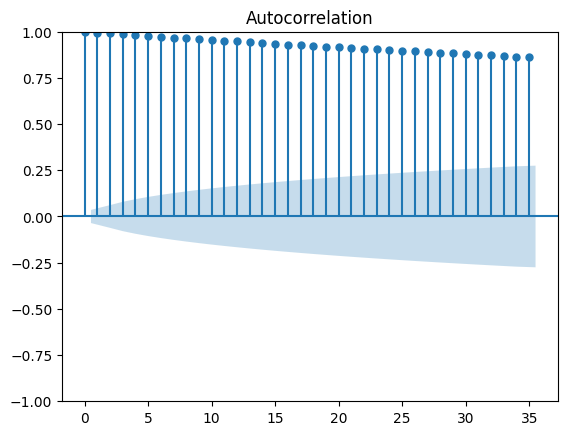

In [10]:
acf_original = plot_acf(price['Close'])

AD-Fuller Test

In [11]:
ad_fuller_result = adfuller(price['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.15395471111781317
p-value: 0.9437921445294652


Given the p-value is > 0.05, this confirms the time series is not stationary.

Plot the Time Series

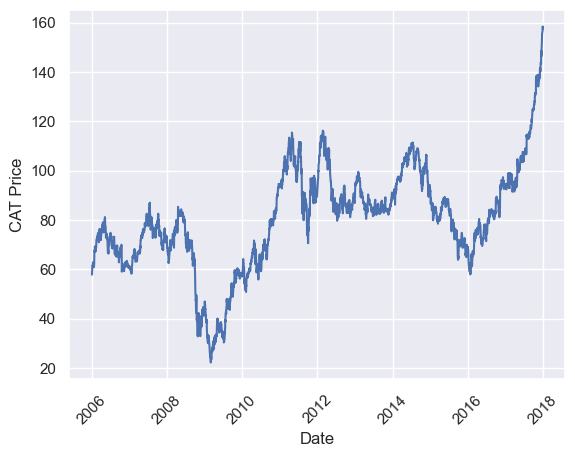

In [12]:
sns.set()
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(price.index, price['Close'], )

Looking at this plot of the 12 years of data we can see there has been both up and down movement with this stock but in the last two years it was on a solid uphill climb. 

In [14]:
df1 = price[['Close']]
decompose_data = seasonal_decompose(df1, model="additive", period=30)

<Axes: xlabel='Date'>

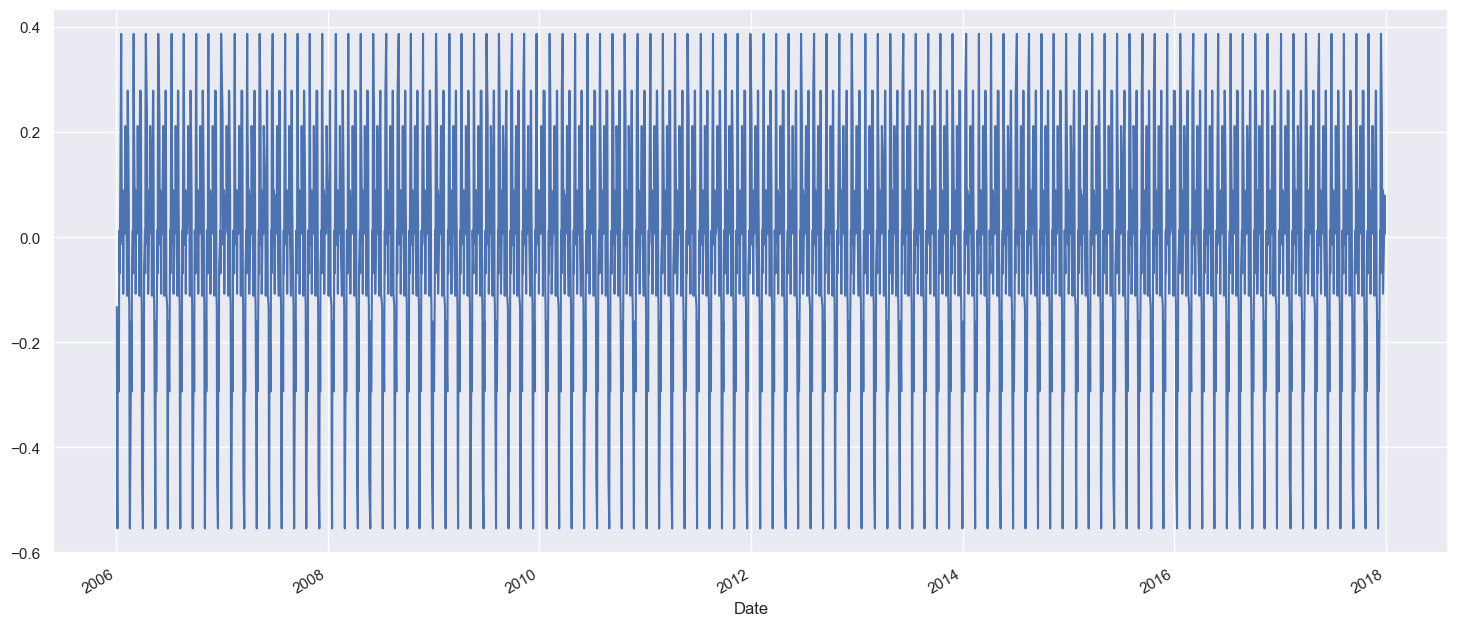

In [15]:
decompose_data.seasonal.plot()

<Axes: xlabel='Date'>

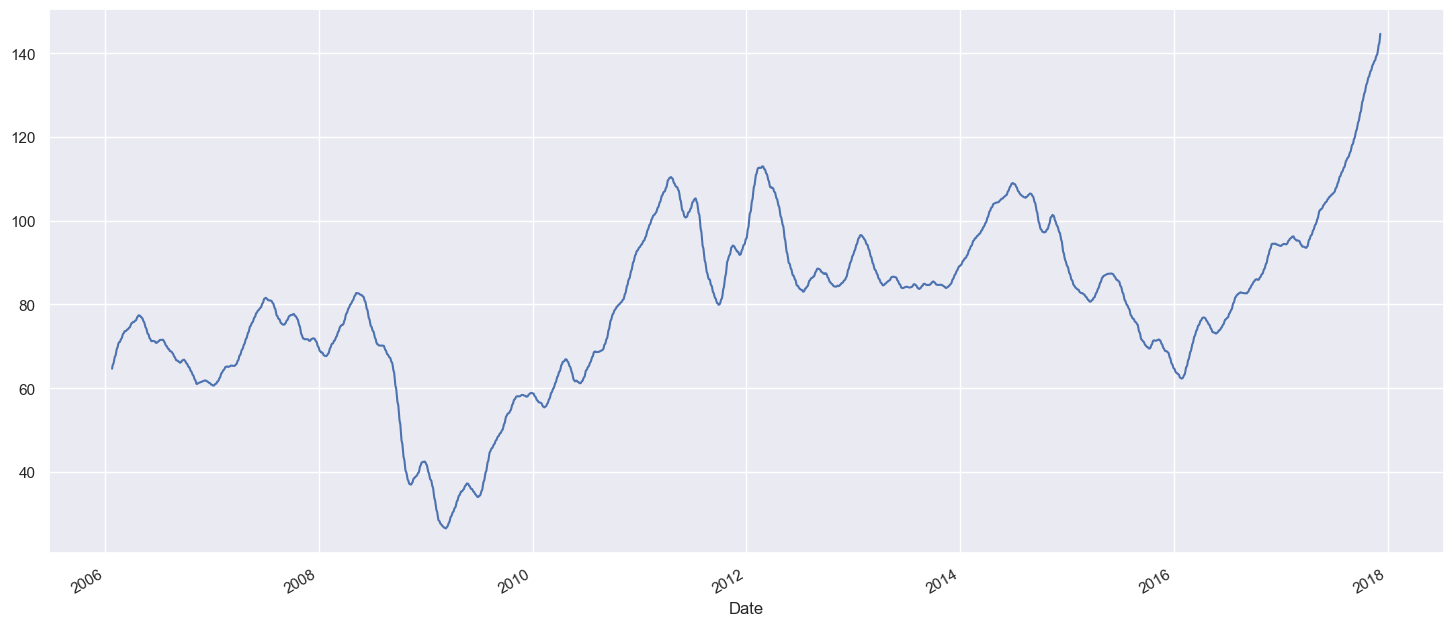

In [16]:
decompose_data.trend.plot()

<Axes: xlabel='Date'>

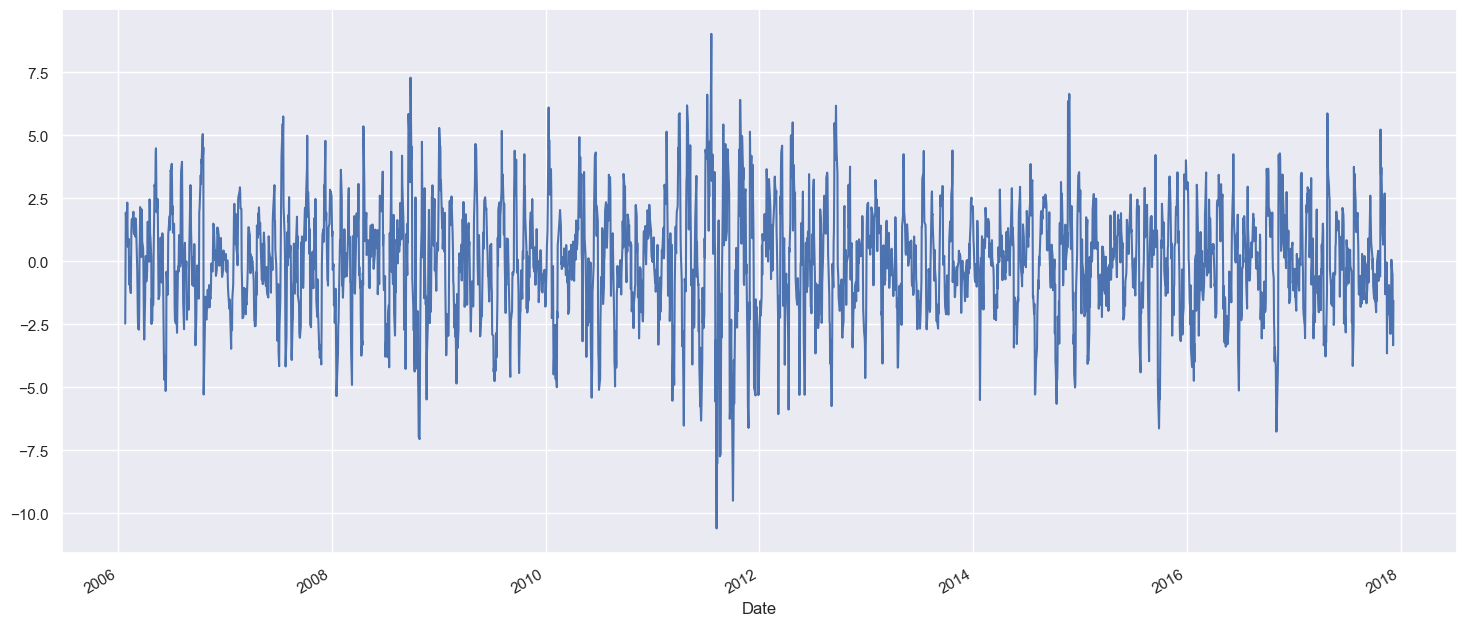

In [17]:
decompose_data.resid.plot()

# Train/Test Split 

I chose to use July 1st 2017 as the split date between training and testing. In 12 years of data that would give us 11.5 years of training data and .5 years of test data. 

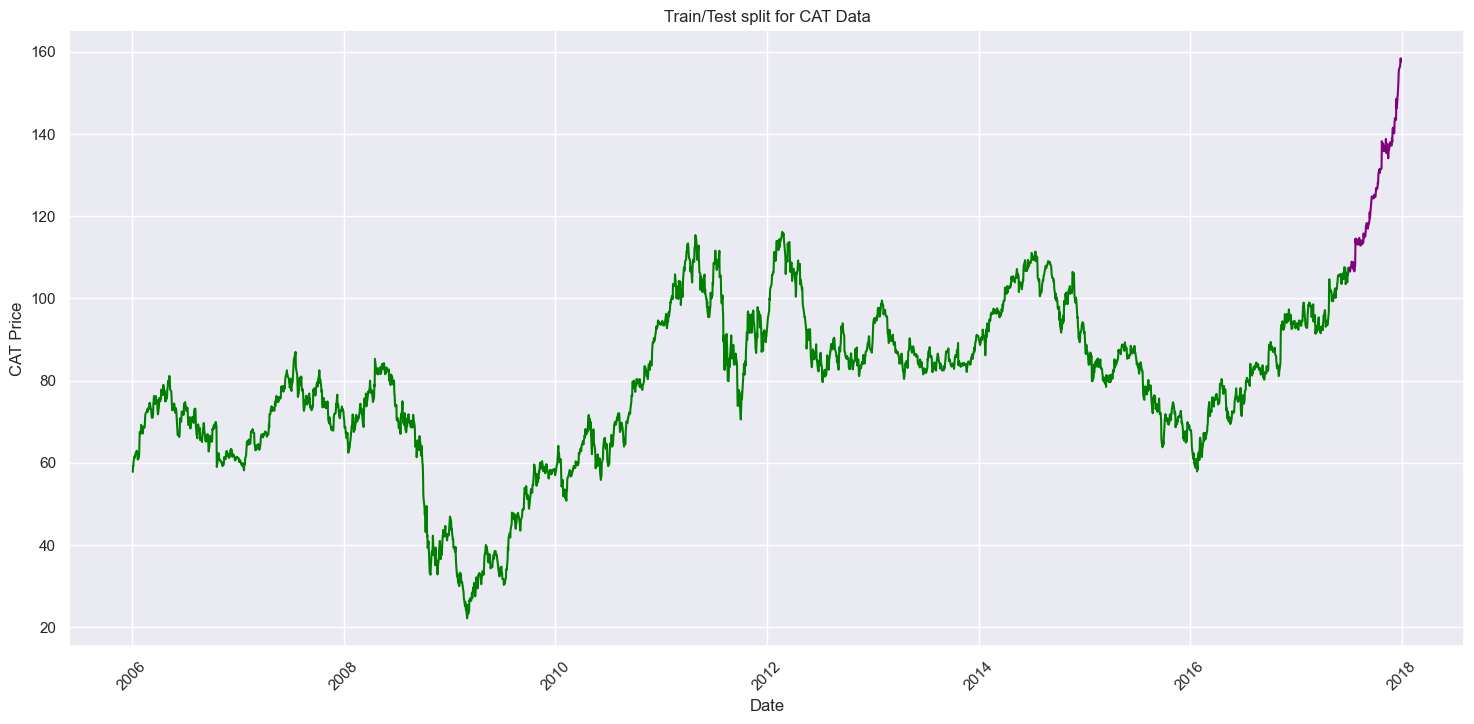

In [18]:
train = price[price.index < pd.to_datetime("2017-07-01", format='%Y-%m-%d')]
test = price[price.index > pd.to_datetime("2017-07-01", format='%Y-%m-%d')]

plt.plot(train.index, train['Close'], color = "green")
plt.plot(test.index, test['Close'], color = "purple") 
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for CAT Data")
plt.show()

ARIMA Model

In [19]:
y = train['Close']

Amodel = ARIMA(y, order = (5, 4, 2))
Amodel = Amodel.fit()

ypred2 = Amodel.get_forecast(len(test.index))
ypred2_df = ypred2.conf_int(alpha = 0.05) 
ypred2_df["Predictions"] = Amodel.predict(start = ypred2_df.index[0], end = ypred2_df.index[-1])
ypred2_df.index = test.index
ypred2_out = ypred2_df["Predictions"] 

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\User

SARIMA Model

In [20]:
y = train['Close']

Smodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
Smodel = Smodel.fit()

ypred3 = Smodel.get_forecast(len(test.index))
ypred3_df = ypred3.conf_int(alpha = 0.05) 
ypred3_df["Predictions"] = Smodel.predict(start = ypred3_df.index[0], end = ypred3_df.index[-1])
ypred3_df.index = test.index
ypred3_out = ypred3_df["Predictions"] 

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dshel\anaconda3\lib\site-p

SARIMA RMSE:  170.4553706921632
ARIMA RMSE:  45.23673853294286


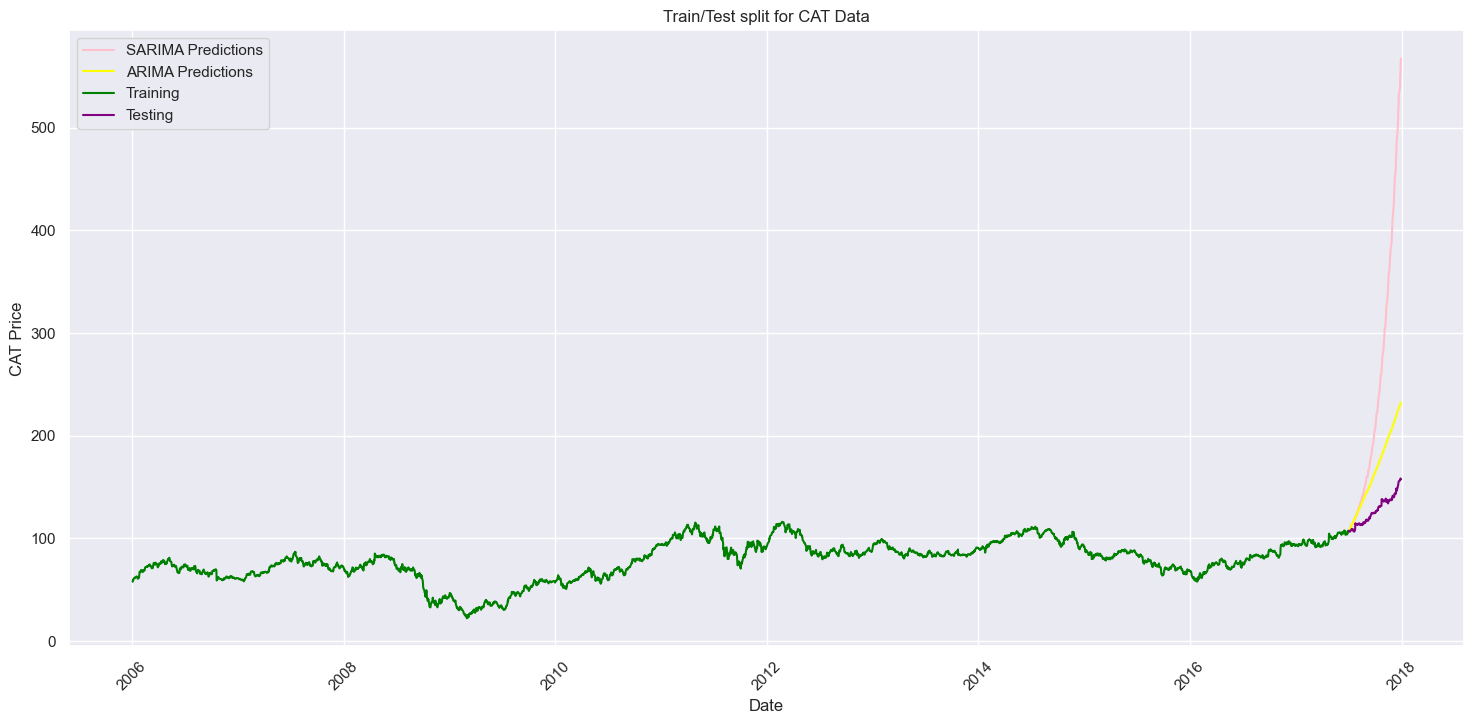

In [21]:
plt.plot(ypred3_out, color='Pink', label = 'SARIMA Predictions')
plt.plot(ypred2_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train.index, train['Close'], color = "Green", label = 'Training')
plt.plot(test.index, test['Close'], color = "Purple", label = 'Testing')
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for CAT Data")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test["Close"].values, ypred3_df["Predictions"]))
print("SARIMA RMSE: ",sarima_rmse)

arima_rmse = np.sqrt(mean_squared_error(test["Close"].values, ypred2_df["Predictions"]))
print("ARIMA RMSE: ",arima_rmse)

Based on both the plot and RMSE scores the ARIMA model is much better then the SARIMA model but there is room for improvement.

I decided to first try adjusting the parameters by making all of them smaller and see what I get. 

In [22]:
y = train['Close']

Amodel1 = ARIMA(y, order = (2, 1, 0))
Amodel1 = Amodel1.fit()

ypred4 = Amodel1.get_forecast(len(test.index))
ypred4_df = ypred4.conf_int(alpha = 0.05) 
ypred4_df["Predictions"] = Amodel1.predict(start = ypred4_df.index[0], end = ypred4_df.index[-1])
ypred4_df.index = test.index
ypred4_out = ypred4_df["Predictions"]

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

In [23]:
y = train['Close']

Smodel1 = SARIMAX(y, order = (2, 1, 0), seasonal_order=(2,2,2,12))
Smodel1 = Smodel1.fit()

ypred5 = Smodel1.get_forecast(len(test.index))
ypred5_df = ypred5.conf_int(alpha = 0.05) 
ypred5_df["Predictions"] = Smodel1.predict(start = ypred5_df.index[0], end = ypred5_df.index[-1])
ypred5_df.index = test.index
ypred5_out = ypred5_df["Predictions"]

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dshel\a

SARIMA RMSE:  22.268358647896278
ARIMA RMSE:  23.815307832761757


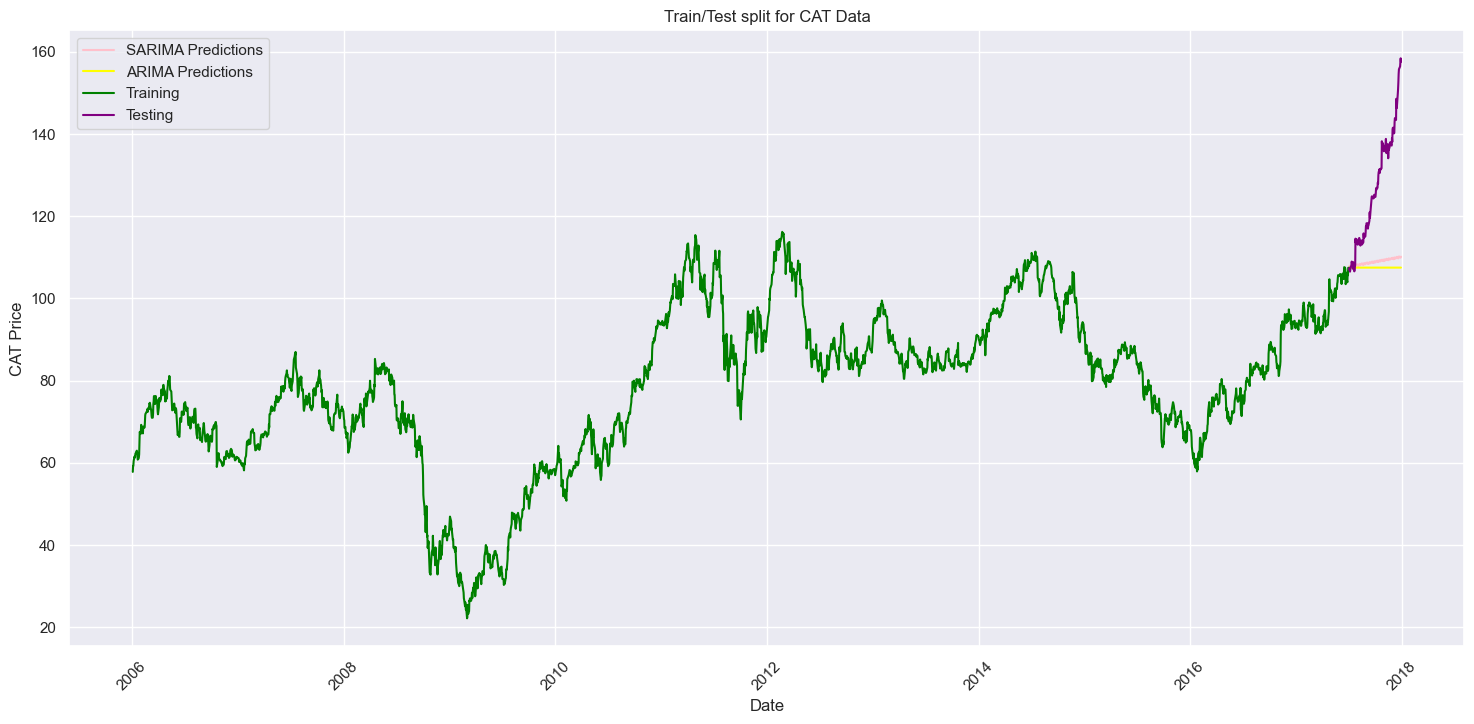

In [24]:
plt.plot(ypred5_out, color='Pink', label = 'SARIMA Predictions')
plt.plot(ypred4_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train.index, train['Close'], color = "Green", label = 'Training')
plt.plot(test.index, test['Close'], color = "Purple", label = 'Testing')
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for CAT Data")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test["Close"].values, ypred5_df["Predictions"]))
print("SARIMA RMSE: ",sarima_rmse)

arima_rmse = np.sqrt(mean_squared_error(test["Close"].values, ypred4_df["Predictions"]))
print("ARIMA RMSE: ",arima_rmse)

After adjusting the parameters, based on the plot and RMSE scores the SARIMA prediction is now better then the ARIMA prediction. On the first attempt they both appeared to move upward in the same direction as the test data but they were overshooting the actual data. With this latest attempt their RMSE scores are better but both predictions are more of a horizontal line that is not going in the same direction as the test data.  

In [25]:
from pmdarima import auto_arima

In [26]:
stepwise_fit = auto_arima(price['Close'], trace='True', suppress_warnings='True')
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10614.526, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10608.336, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10610.288, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10610.290, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10608.015, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10611.911, Time=0.72 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.148 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3020
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5303.007
Date:                Tue, 16 May 2023   AIC                          10608.015
Time:                        16:07:43   BIC                          10614.027
Sample:                             0   HQIC                         10610.177
                               - 3020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.9644      0.030     64.735      0.000       1.905       2.024
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              1612.59
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.14
Prob(H) (two-sided):                  0.54   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

according to this the optimal parameters are (0,1,0) so I'll try them next.

In [27]:
y = train['Close']

Amodel2 = ARIMA(y, order = (0, 1, 0))
Amodel2 = Amodel2.fit()

ypred6 = Amodel2.get_forecast(len(test.index))
ypred6_df = ypred6.conf_int(alpha = 0.05) 
ypred6_df["Predictions"] = Amodel2.predict(start = ypred6_df.index[0], end = ypred6_df.index[-1])
ypred6_df.index = test.index
ypred6_out = ypred6_df["Predictions"]

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

In [28]:
y = train['Close']

Smodel2 = SARIMAX(y, order = (0, 1, 0), seasonal_order=(2,2,2,12))
Smodel2 = Smodel2.fit()

ypred7 = Smodel2.get_forecast(len(test.index))
ypred7_df = ypred7.conf_int(alpha = 0.05) 
ypred7_df["Predictions"] = Smodel2.predict(start = ypred7_df.index[0], end = ypred7_df.index[-1])
ypred7_df.index = test.index
ypred7_out = ypred7_df["Predictions"]

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dshel\a

SARIMA RMSE:  22.320480590246806
ARIMA RMSE:  23.84446330196447


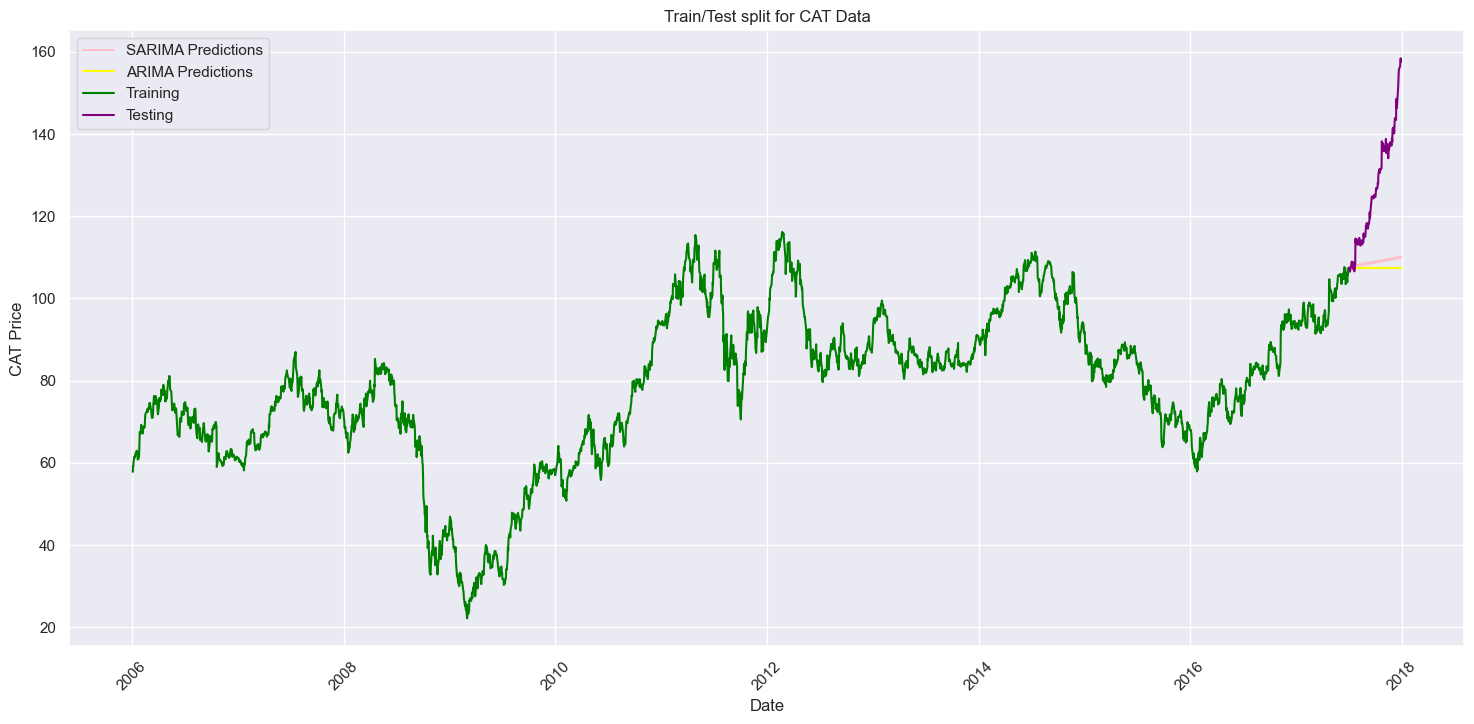

In [29]:
plt.plot(ypred7_out, color='Pink', label = 'SARIMA Predictions')
plt.plot(ypred6_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train.index, train['Close'], color = "Green", label = 'Training')
plt.plot(test.index, test['Close'], color = "Purple", label = 'Testing')
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for CAT Data")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test["Close"].values, ypred7_df["Predictions"]))
print("SARIMA RMSE: ",sarima_rmse)

arima_rmse = np.sqrt(mean_squared_error(test["Close"].values, ypred6_df["Predictions"]))
print("ARIMA RMSE: ",arima_rmse)

The impact using the updated parameters gave us was so small I don't think it is visible on the plot. Yes the RMSE scores were effected ever so slightly but they essentially stayed the same. Additionally, while these may be the most optimal plot for the training data, the fact that they did not line up at all with the test data demonstrates overfitting. 

Train/Test Split - using a smaller test set

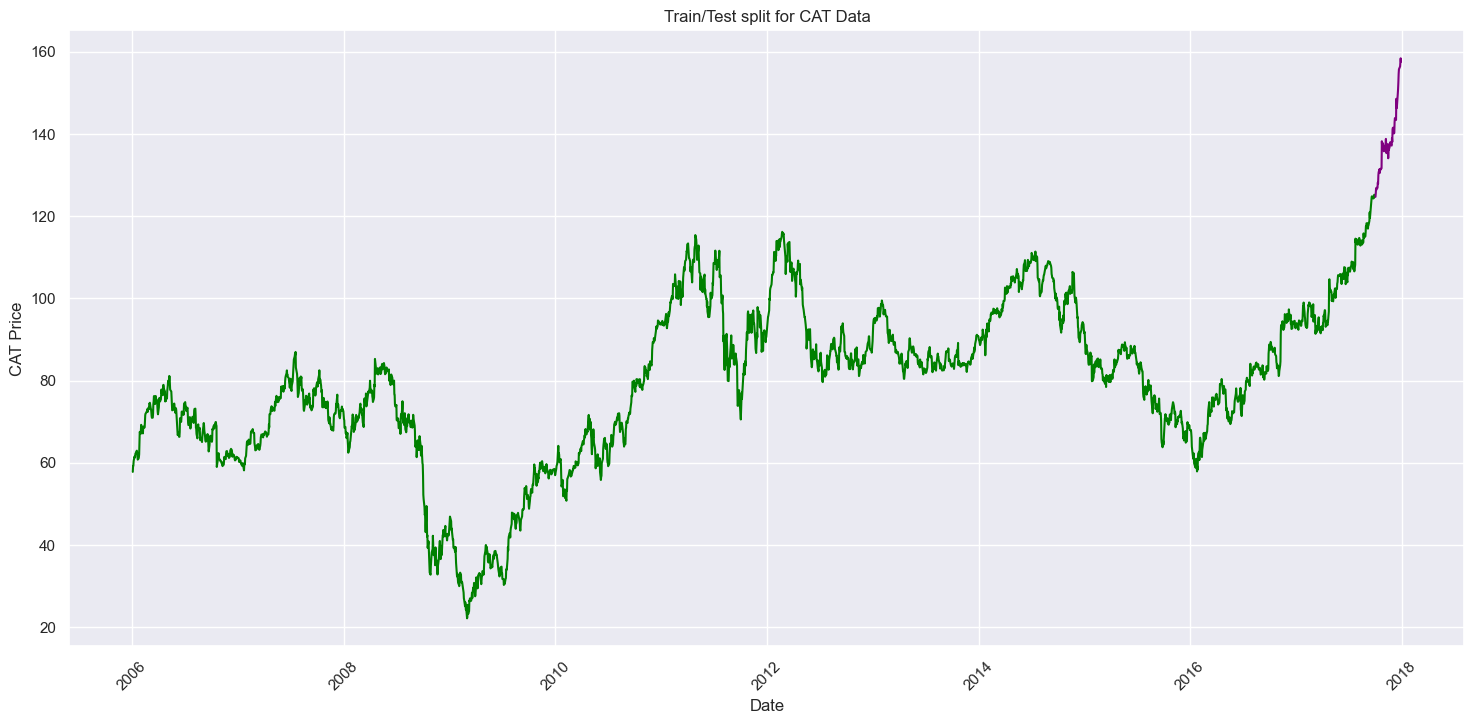

In [30]:
train1 = price[price.index <= pd.to_datetime("2017-10-01", format='%Y-%m-%d')]
test1 = price[price.index > pd.to_datetime("2017-10-01", format='%Y-%m-%d')]

plt.plot(train1.index, train1['Close'], color = "green")
plt.plot(test1.index, test1['Close'], color = "purple") 
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for CAT Data")
plt.show()

In [31]:
y = train1['Close']

Amodel3 = ARIMA(y, order = (4, 4, 2))
Amodel3 = Amodel3.fit()

ypred8 = Amodel3.get_forecast(len(test1.index))
ypred8_df = ypred8.conf_int(alpha = 0.05) 
ypred8_df["Predictions"] = Amodel3.predict(start = ypred8_df.index[0], end = ypred8_df.index[-1])
ypred8_df.index = test1.index
ypred8_out = ypred8_df["Predictions"]

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dshel\a

In [32]:
y = train1['Close']

Smodel3 = SARIMAX(y, order = (4, 4, 2), seasonal_order=(1,1,1,12))
Smodel3 = Smodel3.fit()

ypred9 = Smodel3.get_forecast(len(test1.index))
ypred9_df = ypred9.conf_int(alpha = 0.05) 
ypred9_df["Predictions"] = Smodel3.predict(start = ypred9_df.index[0], end = ypred9_df.index[-1])
ypred9_df.index = test1.index
ypred9_out = ypred9_df["Predictions"]

C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dshel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dshel\anaconda3\lib\sit

SARIMA RMSE:  35.94907778347007
ARIMA RMSE:  10.287290259203528


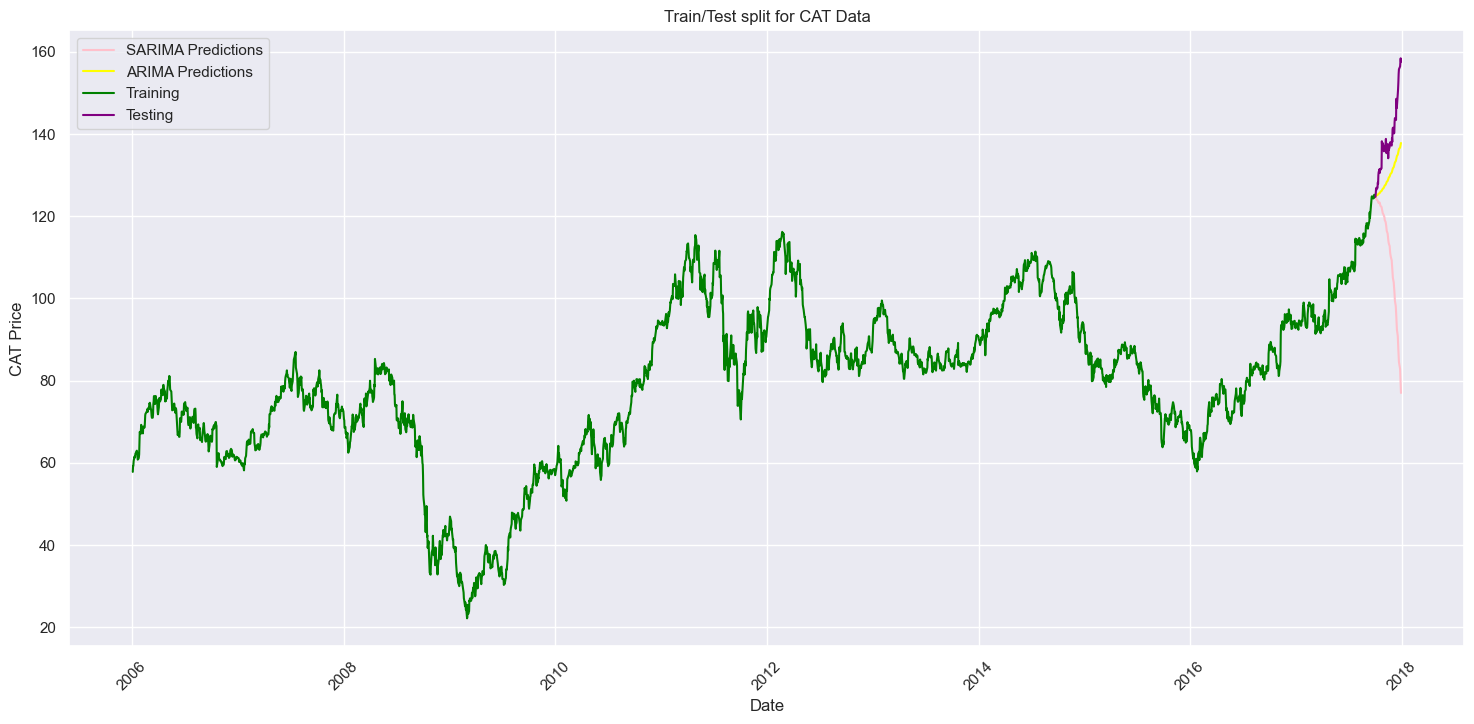

In [33]:
plt.plot(ypred9_out, color='Pink', label = 'SARIMA Predictions')
plt.plot(ypred8_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(train1.index, train1['Close'], color = "Green", label = 'Training')
plt.plot(test1.index, test1['Close'], color = "Purple", label = 'Testing')
plt.ylabel('CAT Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for CAT Data")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test1["Close"].values, ypred9_df["Predictions"]))
print("SARIMA RMSE: ",sarima_rmse)

arima_rmse = np.sqrt(mean_squared_error(test1["Close"].values, ypred8_df["Predictions"]))
print("ARIMA RMSE: ",arima_rmse)

For my final time series I initially worked with the original parameters (5,4,2) where I had the best RMSE scores for both ARIMA and SARIMA of this entire project but the plot was terrible. Given the very first trial I did used these parameters and were at the very least going in the right direction, I decided to make incremental changes to parameters and see what they got me. With this in mind I changed the first parameter, p, to 4 and left everything else the same. This time the ARIMA prediction looks much better and so is its RMSE score. I had a few different ideas with the SARIMA model, but found the only way it makes any sense is if I use (0,0,0,12) which leads me to believe there is no seasonality in this data. Given this is a stock and not daily temperatures, that seems reasonable. Lastly I would say, I still think the reason the auto_arima suggested parameters didn't work is due to overfitting.